In [4]:
import os
import time

import numpy as np
import ipyvolume as ipv
from pathlib import Path

from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.draw.ipv_draw import view_ipv
from tyssue.draw.ipv_draw import sheet_view as ipv_sheet_view
from tyssue.draw.ipv_draw import view_ipv
from tyssue.core.sheet import get_opposite
from tyssue.draw.plt_draw import quick_edge_draw,sheet_view

from invagination.toolbox import open_sheet

import matplotlib.pyplot as plt
%matplotlib inline

SIM_DIR = Path('/home/admin-suz/Documents/Simulations/Collisions/2018-11-14')
#SIM_DIR = Path('/media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/SimulationsReview/2018-06-26/')

old = None

In [5]:
import datetime
today = datetime.date.today()
dirname = SIM_DIR/f'{today.isoformat()}'


dirname = SIM_DIR/'1.6400000000000001_contractility_5_critical_area_50_radialtension/'

## 3D view

In [112]:
sheet.face_df.columns

Index(['z', 'x', 'num_sides', 'area', 'perimeter', 'is_alive', 'y', 'face_o',
       'height', 'rho', 'contractility', 'prefered_area', 'area_elasticity',
       'prefered_height', 'prefered_vol', 'is_mesoderm', 'is_relaxation', 'id',
       'enter_in_process', 'visible'],
      dtype='object')

In [105]:
import ipyvolume.pylab as p3
hfs = [f  for f in os.listdir(dirname)
       if f.endswith('hf5')]
hfs.sort(key=lambda x: os.path.getctime(os.path.join(dirname, x)))


current = 'invagination_0018.hf5'
ipv.clear()
ipv.style.use('dark')


dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face', 'cell'])

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('ellipse', dsets, specs)
sheet.face_df['visible']=True
#sheet = sheet.extract_bounding_box(x_boundary=(-60,60), y_boundary=(0,200))

mean_area = sheet.face_df[~sheet.face_df['is_mesoderm']].area.mean()
rel_area = (sheet.face_df['area'] / mean_area)

face_spec = {'color': sheet.face_df['area'], 
             'color_range': (0, 2),
             'visible': True,
            'alpha': 0.5}

edge_spec = {'color':'green'}
fig, meshes = ipv_sheet_view(sheet, mode='3D', face=face_spec, edge=edge_spec)


fig.anglex = -0.7
fig.angley = 0.2
fig.anglez = 0.8
ipv.show()


VBox(children=(Figure(anglex=-0.7, angley=0.2, anglez=0.8, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('green', dtype='<U5'), lines=array([[11775, 11852],
       [11308, 11625],
       [ 7592,  7593],
       ...,
       [ 4912,  4910],
       [ 8955,  8961],
       [    0,  1365]], dtype=uint32), texture=None, x=array([-30.20560055, -25.62484298,  -2.60351856, ...,   0.83318231,
         0.80157882,   0.86428127]), y=array([-52.02809688,  63.09490429, -61.54360487, ...,  15.83628741,
        15.74074107,  16.03706907]), z=array([106.27881435, -74.27333038, 103.68691805, ..., -31.86340936,
       -31.89082335, -34.57226109])), Mesh(color=array([[0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       ...,
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936]]), texture=None, triangles=array([[ 5795,  5947, 41617],
       [ 5810,  5948, 41618],
       [ 4723,  5949, 41619],
       ...,
       [ 3649, 41614, 77284],
       [ 1467, 41615, 77285],
       [    0, 41616, 77286]], dtype=uint32), x=array([-31.32995349, -31.32835374, -27.44585729, ...,  81.96356361,
       -35.63828349, -32.39711333]), y=array([-53.53021027, -49.62194989, -52.29282509, ...,  12.25713702,
       -57.78349079, -51.12708897]), z=array([102.75446758, 108.68436316, 108.03725107, ..., -35.00216458,
       -90.6732548 , 105.62753146]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-164.90213258360527, 164.94857894259516], ylim=[-164.90213258360527, 164.94857894259516], zlim=[-164.90213258360527, 164.94857894259516]),))

In [115]:
face_mesoderm = sheet.face_df[sheet.face_df['is_mesoderm']].index
edge_mesoderm = sheet.edge_df[sheet.upcast_face(sheet.face_df['is_mesoderm'])].index
vert_mesoderm = sheet.edge_df.loc[edge_mesoderm, 'srce'].unique()

sum_ab_tension = sheet.vert_df.loc[vert_mesoderm, 'radial_tension']
sum_ab_tension = sum_ab_tension[sum_ab_tension > 1e-3].mean()
sum_contract = sheet.face_df.loc[face_mesoderm].eval('perimeter * contractility').mean()

print((sum_ab_tension / sum_contract)) 

0.09339404350348636


In [116]:
from invagination.ellipsoid import model

In [119]:
model.labels

['Apical basal tension',
 'Vitelline elasticity',
 'Contractility',
 'Area elasticity',
 'Volume elasticity']

In [14]:
sheet.face_df

,z,x,num_sides,area,perimeter,is_alive,y,face_o,height,rho,contractility,prefered_area,area_elasticity,prefered_height,prefered_vol,is_mesoderm,id,enter_in_process,vol,visible
face,,,,,,,,,,,,,,,,,,,,
0,120.215956,-27.340452,6,29.949650,20.962829,True,-42.943167,0,55.245645,50.961009,1.120000,28,1,32,896,False,0,0,1656.959562,True
1,125.026894,-27.910939,6,29.351912,21.020711,True,-37.838355,1,55.247317,47.055407,1.120000,28,1,32,896,False,1,0,1642.419673,True
2,124.794433,-24.346174,5,28.050440,20.959265,True,-40.457263,2,55.246596,47.260613,1.120000,28,1,32,896,False,2,0,1508.288970,True
3,-61.781573,-5.285131,6,1.246987,4.422495,True,43.842745,3,21.724548,44.161778,16.425765,28,1,32,896,False,3,0,77.040099,True
4,-61.464282,-5.721829,4,0.183959,1.890447,True,44.407970,4,22.256700,44.775341,18.864039,28,1,32,896,False,4,0,11.008208,True
5,-60.181989,-5.117216,6,3.126882,8.273094,True,43.841582,5,21.303697,44.140219,14.532310,28,1,32,896,False,5,0,27.854531,True
6,117.376403,-3.678909,6,31.195234,22.369782,True,-52.864681,6,55.243679,53.027937,1.120000,28,1,32,896,False,6,0,1722.140250,True
7,123.698456,-4.518726,6,30.090033,22.052731,True,-47.913322,7,55.245322,48.157623,1.120000,28,1,32,896,False,7,0,1661.798153,True
8,122.694613,-0.426359,6,31.095717,21.970726,True,-48.951642,8,55.245531,48.986130,1.120000,28,1,32,896,False,8,0,1715.604038,True


In [122]:
ab_tension, _, contractility, *_ = model.compute_energy(sheet, full_output=True)

In [129]:
(ab_tension.sum() / contractility.loc[face_mesoderm].sum())


0.8850516503288558

In [111]:

sheet.vert_df.loc[vert_mesoderm, 'radial_tension']

vert
7592      4.285714
7595      7.500000
7591      4.285714
11313     0.000000
7597      0.000000
7589      0.000000
7594      7.500000
9346      6.000000
11282     0.000000
11281     0.000000
9347     10.285714
7585      0.000000
7586      0.000000
7577      0.000000
7579      4.285714
7590      0.000000
7587      0.000000
11314     0.000000
7596      0.000000
9675      4.285714
9672      0.000000
7588      0.000000
7593      0.000000
7578      0.000000
11283     0.000000
11284     6.000000
11612     0.000000
11610     0.000000
11286     6.000000
11279     0.000000
           ...    
5377     11.000000
8308      0.000000
8307      0.000000
5614      0.000000
5613      0.000000
5588      5.000000
10003     4.285714
10002     4.285714
8410      0.000000
4392      8.571429
4391      5.000000
4390      0.000000
7263      5.000000
9505      5.000000
4388      0.000000
248       5.000000
247      10.000000
228       0.000000
1298      0.000000
517       4.285714
516       4.285714
4854   

In [45]:
meshes[0]

Mesh(color=array('#8aa678', dtype='<U7'), texture=None, triangles=array([[ 5795,  5947, 41617],
       [ 5810,  5948, 41618],
       [ 4723,  5949, 41619],
       ...,
       [ 3649, 41614, 77284],
       [ 1467, 41615, 77285],
       [    0, 41616, 77286]], dtype=uint32), x=array([-32.63291151, -33.17212082, -29.02680802, ...,   0.        ,
         0.        ,   0.        ]), y=array([-58.21672528, -54.97897636, -57.59577872, ...,   0.        ,
         0.        ,   0.        ]), z=array([93.15554381, 98.51662665, 97.92038856, ...,  0.        ,
        0.        ,  0.        ]))

In [110]:
from tyssue.io import obj
obj.save_junction_mesh('ablated_one.obj', sheet)

                be advised the file cannot be read back in vispy


In [154]:
sheet.face_df[sheet.face_df['is_mesoderm'] & sheet.face_df['is_relaxation']]

,z,x,num_sides,area,perimeter,is_alive,y,face_o,height,rho,contractility,prefered_area,area_elasticity,prefered_height,prefered_vol,is_mesoderm,is_relaxation,id,enter_in_process
face,,,,,,,,,,,,,,,,,,,


In [49]:
import ipyvolume.pylab as p3
hfs = [f  for f in os.listdir(dirname)
       if f.endswith('hf5')]
hfs.sort(key=lambda x: os.path.getctime(os.path.join(dirname, x)))

current = 'invagination_0050.hf5'
ipv.clear()
ipv.style.use('dark')



dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face', 'cell'])

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('ellipse', dsets, specs)

datasets={}
datasets['face'] = sheet.face_df[sheet.face_df['contractility']>=0.5].copy()

datasets['edge'] = sheet.edge_df[sheet.edge_df['face'].isin(
                    datasets['face'].index)].copy()
datasets['vert'] = sheet.vert_df.loc[sheet.edge_df['srce'].unique()].copy()

sheet = Sheet('subsheet', datasets, sheet.specs)
sheet.reset_index()
sheet.reset_topo()

sheet = sheet.extract_bounding_box(x_boundary=(-50,200), y_boundary=(-50,200))


"""mean_area = sheet.face_df[~sheet.face_df['is_mesoderm']].area.mean()
rel_area = (sheet.face_df['area'] / mean_area)"""

mean_area = sheet.face_df.height.mean()
rel_area = 1/(sheet.face_df['height'] / mean_area)

mean_edge = sheet.edge_df.cell.mean()
rel_edge = (sheet.edge_df['cell'] / mean_edge)

face_spec = {'color': rel_area, 
             'color_range': (0.8, 1.8),
             'visible': True,
             'epsilon': 0.1,
            'colormap':'Greens'}

edge_spec = {'color':rel_edge,
            'visible':True,
            'espilon':0.1,
            'colormap':'magma'
            }

fig, meshes = ipv_sheet_view(sheet, mode='3D', face=face_spec, edge=edge_spec)


fig.anglex = -1.3
fig.angley = 0.7
fig.anglez = 0.7
ipv.show()


/home/admin-suz/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: RuntimeWarning: invalid value encountered in reduce
  return getattr(obj, method)(*args, **kwds)
/home/admin-suz/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/admin-suz/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


VBox(children=(Figure(anglex=-1.3, angley=0.7, anglez=0.7, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.001462, 0.000466, 0.013866],
       [0.001462, 0.000466, 0.013866],
       [0.001462, 0.000466, 0.013866],
       ...,
       [0.001462, 0.000466, 0.013866],
       [0.001462, 0.000466, 0.013866],
       [0.001462, 0.000466, 0.013866]]), lines=array([[    0,  2360],
       [    1,    64],
       [    2,   212],
       ...,
       [11880,  2169],
       [11879, 11880],
       [11866, 11879]], dtype=uint32), texture=None, x=array([ 46.11333674, -28.88986948,  -6.01360114, ...,  83.81365364,
        82.96467035,  82.35059749]), y=array([16.61002319, 74.24720964, 65.16028403, ...,  5.9442751 ,
        7.58948475, 10.1314863 ]), z=array([122.71847197, -42.10328246,   7.91769238, ..., -25.00654431,
       -31.51436364, -34.24035665])), Mesh(color=array([[0.90219146, 0.96239908, 0.88327566],
       [0.90219146, 0.96239908, 0.88327566],
       [0.90219146, 0.96239908, 0.88327566],
       ...,
       [0.90219146, 0.96239908, 0.88327566],
       [0.90219146, 0.96239908, 0.88327566],
       [0.90219146, 0.96239908, 0.88327566]]), texture=None, triangles=array([[ 3474,  3572, 24989],
       [ 3487,  3573, 24990],
       [ 2766,  3574, 24991],
       ...,
       [ 2096, 24986, 46403],
       [ 2096, 24987, 46404],
       [ 2096, 24988, 46405]], dtype=uint32), x=array([-42.03360353, -44.55206772, -39.72571259, ...,   0.        ,
         0.        ,   0.        ]), y=array([54.25687899, 55.35396183, 57.25162209, ...,  0.        ,
        0.        ,  0.        ]), z=array([-88.79386952, -82.61579601, -86.18827744, ...,   0.        ,
         0.        ,   0.        ]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-164.90213258360527, 164.94857894259516], ylim=[-164.90213258360527, 164.94857894259516], zlim=[-164.90213258360527, 164.94857894259516]),))

In [28]:
min(rel_area)

0.9155822453150325

In [98]:
"""sheet.face_df
def define_depth_by_cells(directory, t):
    
    # open sheet for depth reference
    sheet = open_sheet(directory, 0)
    try:
        sheet_mesoderm = sheet.extract('is_mesoderm')
    except:
        sheet_mesoderm = sheet.extract('is_fold_patch')
        
    
"""
sheet.face_df[sheet.face_df['is_mesoderm']]
    

,z,x,num_sides,area,perimeter,is_alive,y,face_o,height,rho,contractility,prefered_area,area_elasticity,prefered_height,prefered_vol,is_mesoderm,is_relaxation,id,enter_in_process
face,,,,,,,,,,,,,,,,,,,
19,111.446339,-1.441714,6,2.980913,9.074242,True,35.971643,45,34.195425,36.001523,7.211916,28.0,1,32,896,True,False,45,0
20,114.522037,-0.852764,6,3.824002,9.456428,True,34.769438,46,34.980423,34.782340,6.989308,28.0,1,32,896,True,False,46,0
21,115.729089,-1.598498,7,3.761011,9.537902,True,34.958811,47,36.018468,34.996934,8.587507,28.0,1,32,896,True,False,47,0
22,110.437931,-0.692455,6,3.976878,9.476543,True,35.786139,48,33.358075,35.795562,6.899640,28.0,1,32,896,True,False,48,0
23,115.898047,0.707622,6,4.052999,9.998419,True,34.255414,49,35.404486,34.265967,7.576788,28.0,1,32,896,True,False,49,0
24,111.308264,0.971993,7,3.719628,9.475014,True,35.351697,50,33.475808,35.367498,8.611468,28.0,1,32,896,True,False,50,0
25,114.440275,1.531326,6,3.071535,8.981467,True,34.890233,51,35.066940,34.926078,6.341560,28.0,1,32,896,True,False,51,0
26,107.295759,1.500639,7,4.545691,9.597618,True,36.531136,52,32.241430,36.563331,7.947460,28.0,1,32,896,True,False,52,0
27,107.628715,0.869239,5,1.927422,7.519210,True,36.092414,53,31.973069,36.104959,5.503148,28.0,1,32,896,True,False,53,0


## Ventral view of cells at the beginning

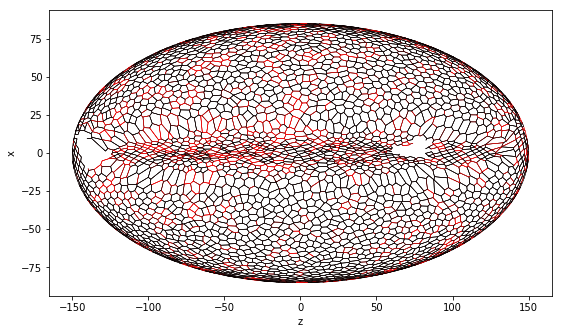

In [47]:
draw_specs = config.draw.sheet_spec()
sheet = open_sheet(dirname, 1)
sheet = sheet.extract_bounding_box(y_boundary=[0, 100])
fig, ax = plt.subplots()
edge_mask = 'is_mesoderm'
edge_mask_color_map='hot'
coords=['z', 'x']

list_edge_in_mesoderm = sheet.edge_df['face'].isin(
    sheet.face_df[sheet.face_df[edge_mask]].index)

cmap_edge = np.ones(sheet.edge_df.shape[0]) * list_edge_in_mesoderm/4
sheet.edge_df['col'] = cmap_edge / (max(cmap_edge))/4

cmap_edge = plt.cm.get_cmap(edge_mask_color_map, 4)
edge_color_cmap = cmap_edge(sheet.edge_df.col)
draw_specs['edge']['color'] = edge_color_cmap

draw_specs['edge']['visible'] = True
draw_specs['edge']['alpha'] = 0.7
draw_specs['vert']['visible'] = False
draw_specs['face']['visible'] = False
draw_specs['face']['alpha'] = 0.6

fig, ax = sheet_view(sheet, coords=coords, ax=ax, **draw_specs)
ax.set_xlabel(coords[0])
ax.set_ylabel(coords[1])

fig.set_size_inches(9.25, 5.25, forward=True)


ax.grid(False)
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
#ax.axis('off')

In [127]:
sheet.vert_df[(sheet.vert_df.z>-15) & (sheet.vert_df.z<15)]['radial_tension'].unique()

array([0.])

/home/admin-suz/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


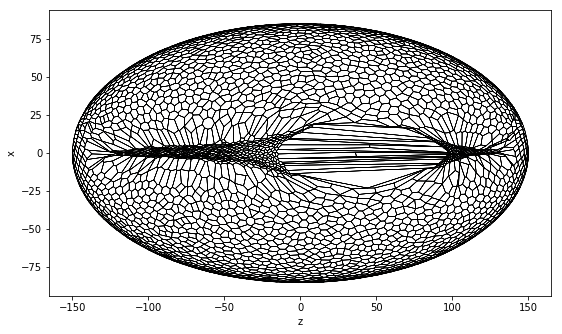

In [15]:
draw_specs = config.draw.sheet_spec()
sheet = open_sheet(dirname, 50)
sheet = sheet.extract_bounding_box(y_boundary=[0, 100])
fig, ax = plt.subplots()
edge_mask_color_map='gist_gray'
coords=['z', 'x']

list_cutting_edge = sheet.edge_df['face'].isin(
    sheet.face_df[sheet.face_df['contractility']<0.01].index)

cmap_edge = np.ones(sheet.edge_df.shape[0]) * list_cutting_edge
sheet.edge_df['col'] = cmap_edge / (max(cmap_edge))

cmap_edge = plt.cm.get_cmap(edge_mask_color_map, 2)
edge_color_cmap = cmap_edge(sheet.edge_df.col)
draw_specs['edge']['color'] = edge_color_cmap

draw_specs['edge']['visible'] = True
draw_specs['edge']['alpha'] = 1
draw_specs['vert']['visible'] = False
draw_specs['face']['visible'] = False
draw_specs['face']['alpha'] = 0.6

fig, ax = sheet_view(sheet, coords=coords, ax=ax, **draw_specs)
ax.set_xlabel(coords[0])
ax.set_ylabel(coords[1])

fig.set_size_inches(9.25, 5.25, forward=True)


ax.grid(False)
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
#ax.axis('off')
#fig.savefig('../post_ablation.png', dpi = 150)

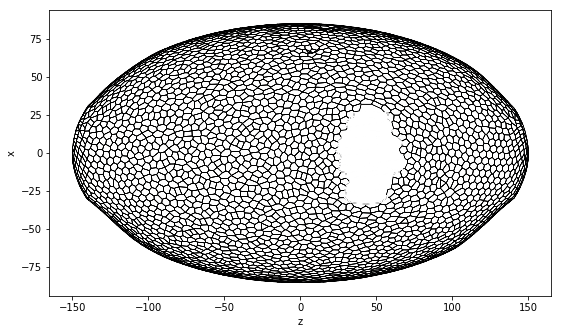

In [31]:
SIM_DIR = Path('/home/admin-suz/Documents/short_simulation/file_to_copy/2018-09-08_TEST3')
dirname = SIM_DIR/'1.08_contractility_5_critical_area_30_radialtension_0/'

draw_specs = config.draw.sheet_spec()
sheet = open_sheet(dirname, 1)
sheet = sheet.extract_bounding_box(y_boundary=[0, 150])
fig, ax = plt.subplots()
edge_mask_color_map='gist_gray'
coords=['z', 'x']

list_cutting_edge = sheet.edge_df['face'].isin(
    sheet.face_df[sheet.face_df['contractility']<=0.5].index)

cmap_edge = np.ones(sheet.edge_df.shape[0]) * list_cutting_edge
sheet.edge_df['col'] = cmap_edge / (max(cmap_edge))

cmap_edge = plt.cm.get_cmap(edge_mask_color_map, 2)
edge_color_cmap = cmap_edge(sheet.edge_df.col)
draw_specs['edge']['color'] = edge_color_cmap

draw_specs['edge']['visible'] = True
draw_specs['edge']['alpha'] = 1
draw_specs['vert']['visible'] = False
draw_specs['face']['visible'] = False
draw_specs['face']['alpha'] = 0.6

fig, ax = sheet_view(sheet, coords=coords, ax=ax, **draw_specs)
ax.set_xlabel(coords[0])
ax.set_ylabel(coords[1])

fig.set_size_inches(9.25, 5.25, forward=True)


ax.grid(False)
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)

#ax.axis('off')
fig.savefig('../post_ablation.png', dpi = 300)

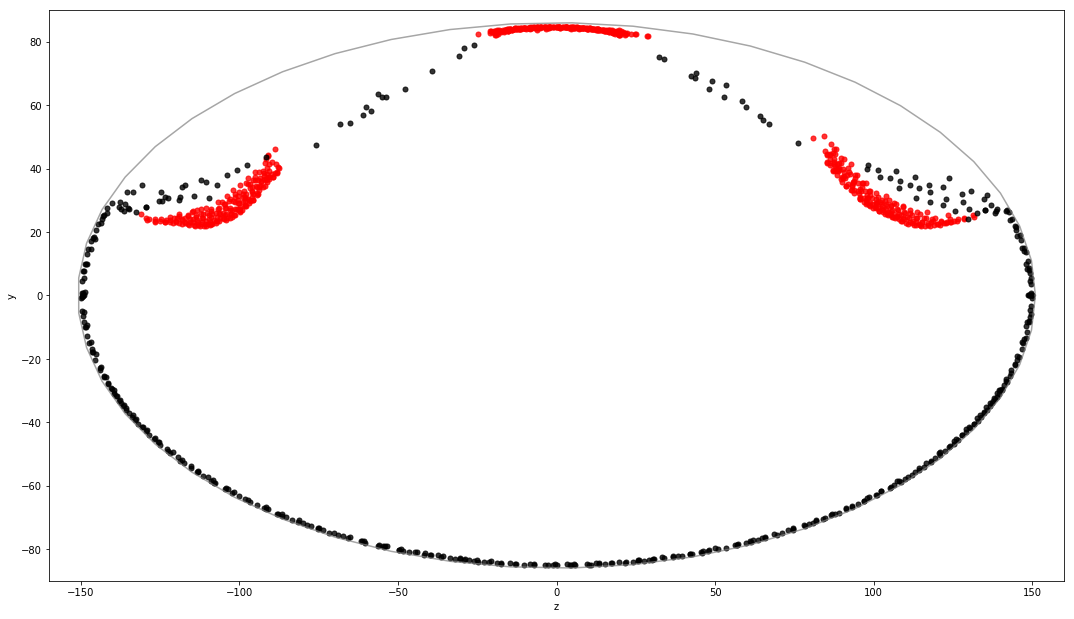

In [172]:
import matplotlib.gridspec as gridspec
SIM_DIR = Path('/home/admin-suz/Documents/SimulationsReview/2018-09-09_TEST5')
dirname = SIM_DIR/'1.08_contractility_5_critical_area_30_radialtension_5/'
sheet = open_sheet(dirname, 50)
sheet_mesoderm = sheet.extract('is_mesoderm')

sheet_mesoderm = sheet.face_df[(sheet.face_df['contractility']!=0) & 
                              (sheet.face_df['is_mesoderm'])]
sheet_ectoderm = sheet.face_df[(~sheet.face_df['is_mesoderm']) & (sheet.face_df.x>-10)&(sheet.face_df.x<10)]

edge_specs = {'alpha': 0.6,
              'lw': 0.1,
              'color': 'white'}
scatter_specs = {'alpha': 0.8,
                 'ms': 5,
                 'color': 'red'}


#plt.figure(figsize=(18.5, 10.5))
fig, ax = plt.subplots(figsize=(18.5, 10.5))



#Retire visuellement les cellules qui ont été ablaté apicalement
datasets={}
datasets['face'] = sheet.face_df[sheet.face_df['contractility']!=0].copy()

datasets['edge'] = sheet.edge_df[sheet.edge_df['face'].isin(
                    datasets['face'].index)].copy()
datasets['vert'] = sheet.vert_df.loc[sheet.edge_df['srce'].unique()].copy()

sheet = Sheet('subsheet', datasets, sheet.specs)
sheet.reset_index()
sheet.reset_topo()



u, v = ('z', 'y')
fig, ax = quick_edge_draw(sheet.extract_bounding_box(x_boundary=(-10,10)),
                          coords=('z', 'y'),
                          ax = ax,
                          **edge_specs)

ax.plot(sheet_mesoderm[u],
        sheet_mesoderm[v],
        'o', **scatter_specs)
scatter_specs = {'alpha': 0.8,
                 'ms': 5,
                 'color': 'k'}
ax.plot(sheet_ectoderm[u],
        sheet_ectoderm[v],
        'o', **scatter_specs)
"""
sheet_dead = sheet.face_df[sheet.face_df['contractility']!=0]
scatter_specs2 = {'alpha': 1,
                 'ms': 5.5,
                 'color': 'white'}
ax.plot(sheet_dead[u],
        sheet_dead[v],
        'o', **scatter_specs2)
        """


"""sheet = sheet.extract_bounding_box(x_boundary=(-10,10))
res=(sheet.edge_df[(sheet.edge_df.srce.isin(sheet.vert_df[sheet.vert_df.radial_tension==0].index))
                           &
                           (sheet.edge_df.trgt.isin(sheet.vert_df[sheet.vert_df.radial_tension==0].index))])
for f in res.face.unique() : 
    if len(res[res.face==f]) == 1:
        res= res.drop(res[res.face==f].index)
sheet_no_force = sheet.face_df[(sheet.face_df.index.isin(res.face.unique())) & sheet.face_df.is_mesoderm == True]
scatter_specs2 = {'alpha': 1,
                 'ms': 5.5,
                 'color': 'orange'}
ax.plot(sheet_no_force[u],
        sheet_no_force[v],
        'o', **scatter_specs2)"""

ax.set_ylim(-90,90)
ax.set_xlim(-160,160)

ax.set_xlabel(u)
ax.set_ylabel(v)

a = 86
c = 151
thetas = np.linspace(0, 2 * np.pi)
ax.plot(c * np.cos(thetas), a * np.sin(thetas), color='grey', alpha=0.7)


#plt.savefig('../TEST5_simul_15_coupe_50.png', dpi = 300)

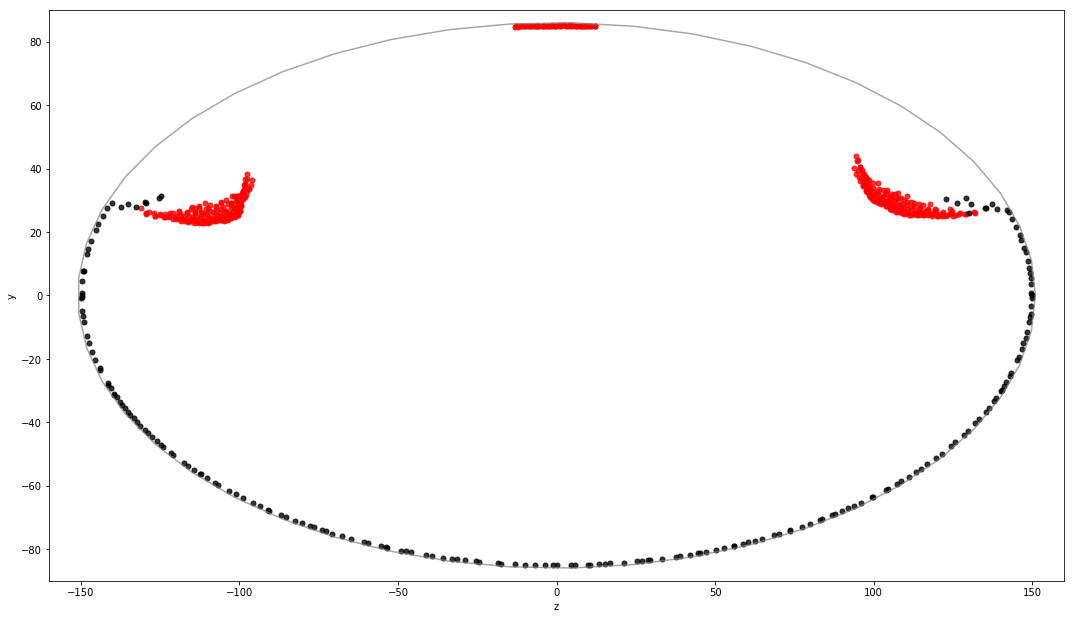

In [23]:
import matplotlib.gridspec as gridspec
SIM_DIR = Path('/home/admin-suz/Documents/short_simulation/file_to_copy/2018-09-09_TEST5')
dirname = SIM_DIR/'1.08_contractility_5_critical_area_30_radialtension_0/'
sheet = open_sheet(dirname, 50)

sheet_mesoderm = sheet.face_df[(sheet.face_df['is_mesoderm']) & (sheet.face_df.x>-5)&(sheet.face_df.x<5)]
sheet_ectoderm = sheet.face_df[(~sheet.face_df['is_mesoderm']) & (sheet.face_df.x>-5)&(sheet.face_df.x<5)
                              & (sheet.face_df.y>-100)&(sheet.face_df.y<32)]

edge_specs = {'alpha': 0.6,
              'lw': 0.1,
              'color': 'white'}
scatter_specs = {'alpha': 0.8,
                 'ms': 5,
                 'color': 'red'}


#plt.figure(figsize=(18.5, 10.5))
fig, ax = plt.subplots(figsize=(18.5, 10.5))



#Retire visuellement les cellules qui ont été ablaté apicalement
datasets={}
datasets['face'] = sheet.face_df[sheet.face_df['contractility']!=0].copy()

datasets['edge'] = sheet.edge_df[sheet.edge_df['face'].isin(
                    datasets['face'].index)].copy()
datasets['vert'] = sheet.vert_df.loc[sheet.edge_df['srce'].unique()].copy()

sheet = Sheet('subsheet', datasets, sheet.specs)
sheet.reset_index()
sheet.reset_topo()



u, v = ('z', 'y')
fig, ax = quick_edge_draw(sheet.extract_bounding_box(x_boundary=(-10,10)),
                          coords=('z', 'y'),
                          ax = ax,
                          **edge_specs)

ax.plot(sheet_mesoderm[u],
        sheet_mesoderm[v],
        'o', **scatter_specs)
scatter_specs = {'alpha': 0.8,
                 'ms': 5,
                 'color': 'k'}
ax.plot(sheet_ectoderm[u],
        sheet_ectoderm[v],
        'o', **scatter_specs)

ax.set_ylim(-90,90)
ax.set_xlim(-160,160)

ax.set_xlabel(u)
ax.set_ylabel(v)

a = 86
c = 151
thetas = np.linspace(0, 2 * np.pi)
ax.plot(c * np.cos(thetas), a * np.sin(thetas), color='grey', alpha=0.7)
#ax.plot(sheet.vert_df.z, sheet.vert_df['is_active']*20, 'ko')

plt.savefig('../TEST5_simul_0_coupe_50.png', dpi = 300)